In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
%matplotlib inline

Essas são visualizações relacionadas à configuração 100 indivíduos e 300 gerações variando a forma de seleção. Já havia feito a seleção roleta para os primeiros testes (notebook 6). Agora, também temos resultados para a seleção por torneio e lexicase.

Esse notebook é uma cópia do notebook 2, apenas alterando os dados.

# 1 - Fitness por execução

In [2]:
results_folder_path = pathlib.Path('../../results/')

In [10]:
def get_fitness_data_per_config(folders_paths) -> list[dict]:
    data_per_config = dict()
    for target_folder in folders_paths:
        fitness_stats_path = target_folder / 'fitness_stats.csv'
        print(fitness_stats_path)
        stats_df = pd.read_csv(fitness_stats_path)
        folder_name_splitted = str(target_folder).split('/')[-1].split('_')
        if len(folder_name_splitted) < 3:
            config_name = 'roul'
        else:
            config_name = folder_name_splitted[-1]
        
        data_per_config[config_name] = stats_df
    return data_per_config

In [11]:
results_folders = list(results_folder_path.glob("concrete/100pop_[53]00gen*"))
data_per_selection = get_fitness_data_per_config(results_folders)

../../results/concrete/100pop_300gen_tour/fitness_stats.csv
../../results/concrete/100pop_500gen/fitness_stats.csv


In [14]:
data_per_selection['tour'].head()

,train_fit,test_fit,train_time_seconds,random_seed
0,15.980594,15.505709,298.315686,261
1,16.804666,16.304275,32.512534,99
2,15.980594,15.505709,320.726464,261
3,15.372701,14.826233,36.042617,753
4,15.372701,14.826233,32.902182,778


In [15]:
def plot_fitness_results(data_dict, num_runs=30, base_dados='synth1'):
    train_data_colors = {'lexi':'red', 
                     'roul':'green', 
                     'tour':'grey'}

    test_data_colors = {'lexi':'orange', 
                     'roul':'cyan', 
                     'tour':'black'}

    x = range(num_runs)
    fig, ax = plt.subplots(figsize=(9, 6))
    for config, data in data_dict.items():
            ax.plot(x, data['train_fit'], color=train_data_colors[config], label=config+" train")
            ax.plot(x, data['test_fit'], color=test_data_colors[config], label=config+" test")

    plt.title(f"Melhor Fitness treino e teste base {base_dados} variando seleções")
    plt.xlabel("Número da Execução")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

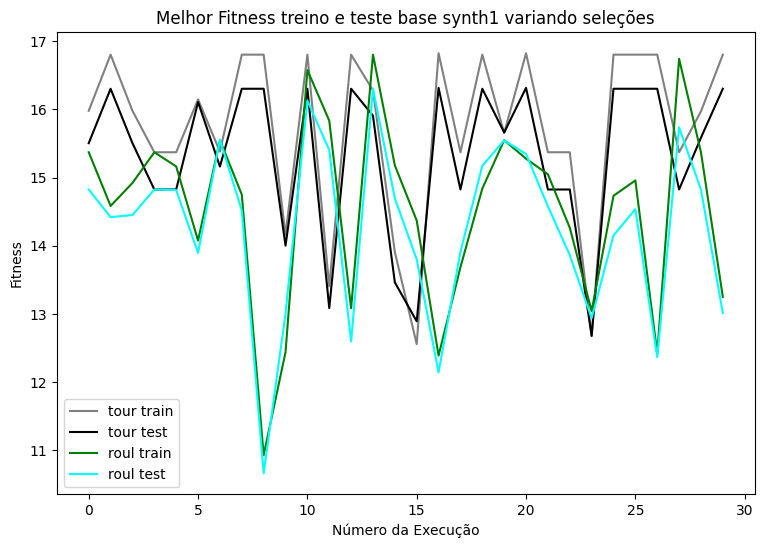

In [16]:
plot_fitness_results(data_per_selection)

In [17]:
def get_trimmed_mean_train_test_fitness(data_dict, trim=0.05)-> dict[str, dict]:
    config_dict_results = dict()
    for config, data in data_dict.items():
        config_dict_results[config] = dict()
        config_dict_results[config]['train'] = scipy.stats.trim_mean(data.train_fit, trim)
        config_dict_results[config]['test'] = scipy.stats.trim_mean(data.test_fit, trim)
    return config_dict_results

In [18]:
mean_fit_results = get_trimmed_mean_train_test_fitness(data_per_selection)
mean_fit_results

{'tour': {'train': 15.809175629350557, 'test': 15.400109550094385},
 'roul': {'train': 14.602458799234208, 'test': 14.32456267753243}}

In [20]:
train_results = [data['train'] for config, data in mean_fit_results.items()]
test_results = [data['test'] for config, data in mean_fit_results.items()]
results_dict = {'train': train_results, 'test':test_results}
results_df = pd.DataFrame(results_dict)
results_df.index = ['roullete', 'tournament']

In [21]:
results_df

,train,test
roullete,15.809176,15.400110
tournament,14.602459,14.324563


Text(0, 0.5, 'Fitness média')

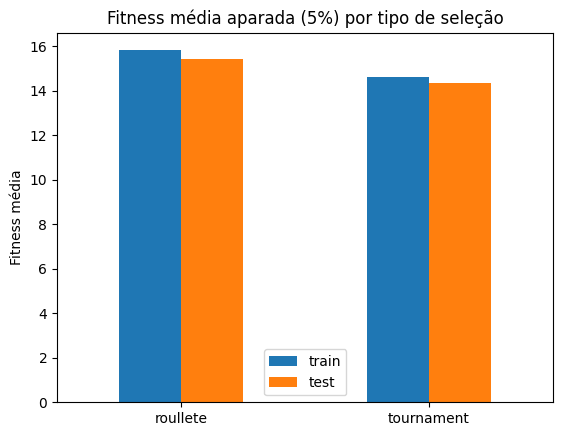

In [23]:
results_df.plot(kind='bar')
plt.title("Fitness média aparada (5%) por tipo de seleção")
plt.xticks(rotation=0)
plt.ylabel("Fitness média")

A seleção por Torneio é levemente melhor do que a roleta.

# 2 - Tempo de execução

In [24]:
def get_trimmed_mean_train_time(data_dict, trim=0.05)-> dict[str, dict]:
    config_dict_results = dict()
    for config, data in data_dict.items():
        config_dict_results[config] = scipy.stats.trim_mean(data.train_time_seconds, trim)
    return config_dict_results

In [25]:
mean_time = get_trimmed_mean_train_time(data_per_selection)
mean_time

{'tour': 105.34406792266029, 'roul': 127.75433250835964}

In [27]:
time_df = pd.DataFrame(mean_time, index=['mean_time']).T
time_df

,mean_time
tour,105.344068
roul,127.754333


A seleção por torneio roda alguns segundos a menos na média por iteração.

# 3 - Best fitness ao longo das gerações

In [30]:
def get_300_gen_stats_df_dict_by_run_of_folder(folder):
    files = list(folder.glob("stats*"))
    stats_dict = dict()
    for file in files:
        file_num = str(file).split('_')[-1].split('.')[0]
        df = pd.read_csv(file)
        df = df.head(300)
        stats_dict[int(file_num)] = df
    return stats_dict

In [31]:
results_folders

[PosixPath('../../results/concrete/100pop_300gen_tour'),
 PosixPath('../../results/concrete/100pop_500gen')]

In [32]:
tour_dict_dfs = get_300_gen_stats_df_dict_by_run_of_folder(results_folders[0])
roul_dict_dfs = get_300_gen_stats_df_dict_by_run_of_folder(results_folders[1])

In [33]:
def get_line_and_col_of_runs(df_dict, target_line, target_cols:list):
    results_list_of_dicts = list()
    for df_num, df in df_dict.items():
        results_list_of_dicts.append(df.iloc[target_line][target_cols].to_dict())
    
    return pd.DataFrame(results_list_of_dicts)
def get_col_stats_from_dfs_dict(df_dict, target_col):
    records_list = list()
    for gen in range(300):
        curr_values = get_line_and_col_of_runs(df_dict, gen, [target_col]).values.flatten()
        min_value = np.min(curr_values)
        max_value = np.max(curr_values)
        mean_value = np.mean(curr_values)
        new_record = {'min_value':min_value, 'max_value':max_value, 'mean_value':mean_value}
        records_list.append(new_record)

    return pd.DataFrame.from_records(records_list)

In [34]:
best_fit_per_gen_tour_df = get_col_stats_from_dfs_dict(tour_dict_dfs, 'best_fit')
best_fit_per_gen_roul_df = get_col_stats_from_dfs_dict(roul_dict_dfs, 'best_fit')

In [35]:
def plot_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    y = stats_df['mean_value']
    y1 = stats_df['min_value']
    y2 = stats_df['max_value']
    my_axs.plot(x, y, '-', label=label)
    my_axs.fill_between(x, y1, y2, alpha=0.2)

Text(0.5, 1.0, 'Melhor fitness média para 30 runs e 100 indivíduos')

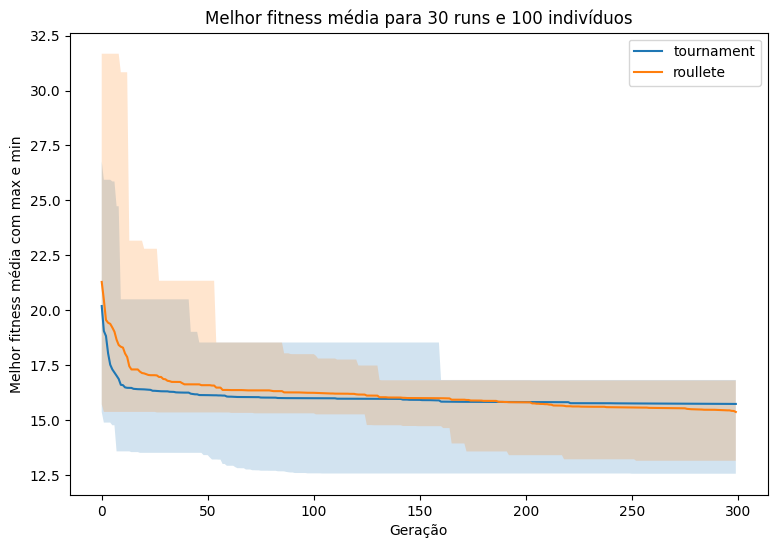

In [36]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_fill_between(best_fit_per_gen_tour_df, ax, 'tournament')
plot_fill_between(best_fit_per_gen_roul_df, ax, 'roullete')

ax.legend()
ax.set_ylabel("Melhor fitness média com max e min")
ax.set_xlabel("Geração")
ax.set_title("Melhor fitness média para 30 runs e 100 indivíduos")

O gráfico mostra que ambos tipos de seleção possuem um movimento semelhante. Com cerca de 150 gerações eles já atingem uma solução muito próxima da melhor encontrada. Também é possível ver que a melhor solução por torneio é levemente melhor do que a por roleta, mesmo que, na média, a por roleta também seja levemente melhor.

# 4 - Comparando melhor execução dos três métodos de seleção

In [37]:
def get_best_test_line_for_selection(select_type):
    target = f'{select_type}'
    config = data_per_selection[select_type]
    print(f"Melhor linha para seleção {select_type}: ")
    best_run = config[config.test_fit == config.test_fit.min()] 
    print(best_run)
    return best_run

In [38]:
roul_best_run_stats = get_best_test_line_for_selection('roul')
tour_best_run_stats = get_best_test_line_for_selection('tour')

Melhor linha para seleção roul: 
   train_fit   test_fit  train_time_seconds  random_seed
8  10.927778  10.663643          225.471627          513
Melhor linha para seleção tour: 
    train_fit   test_fit  train_time_seconds  random_seed
23   12.67457  12.680118          149.943459          406


In [41]:
best_roul_run = roul_dict_dfs[8]
best_tour_run = tour_dict_dfs[23]

In [42]:
def plot_run_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    min_y = stats_df['best_fit']
    std_y = stats_df['std_fit']
    mean_y = stats_df['mean_fit']
    my_axs.plot(x, min_y, '-', label=label)
    my_axs.fill_between(x, min_y, mean_y, alpha=0.2)

Text(0.5, 1.0, 'Best Fitness ao longo das gerações para as melhores execuções')

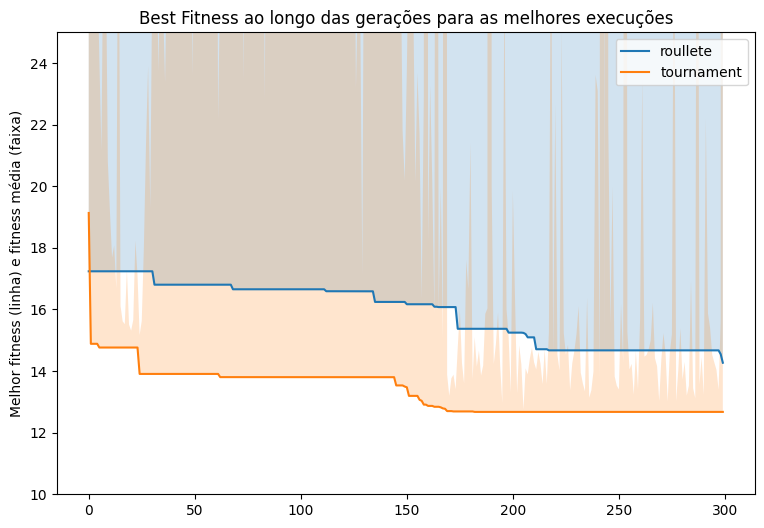

In [44]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_run_fill_between(best_roul_run, ax, 'roullete')
plot_run_fill_between(best_tour_run, ax, 'tournament')

ax.set_ylim((10, 25))
ax.legend()
ax.set_ylabel("Melhor fitness (linha) e fitness média (faixa)")
ax.set_title("Best Fitness ao longo das gerações para as melhores execuções")

Com 300 gerações, a melhor execução da seleção por torneio foi melhor do que a seleção por roleta. A seleção por torneio é mais rápida e, no melhor caso, foi melhor do que a seleção por roleta.

Dessa forma, usaremos a seleção por torneio nos próximos experimentos.